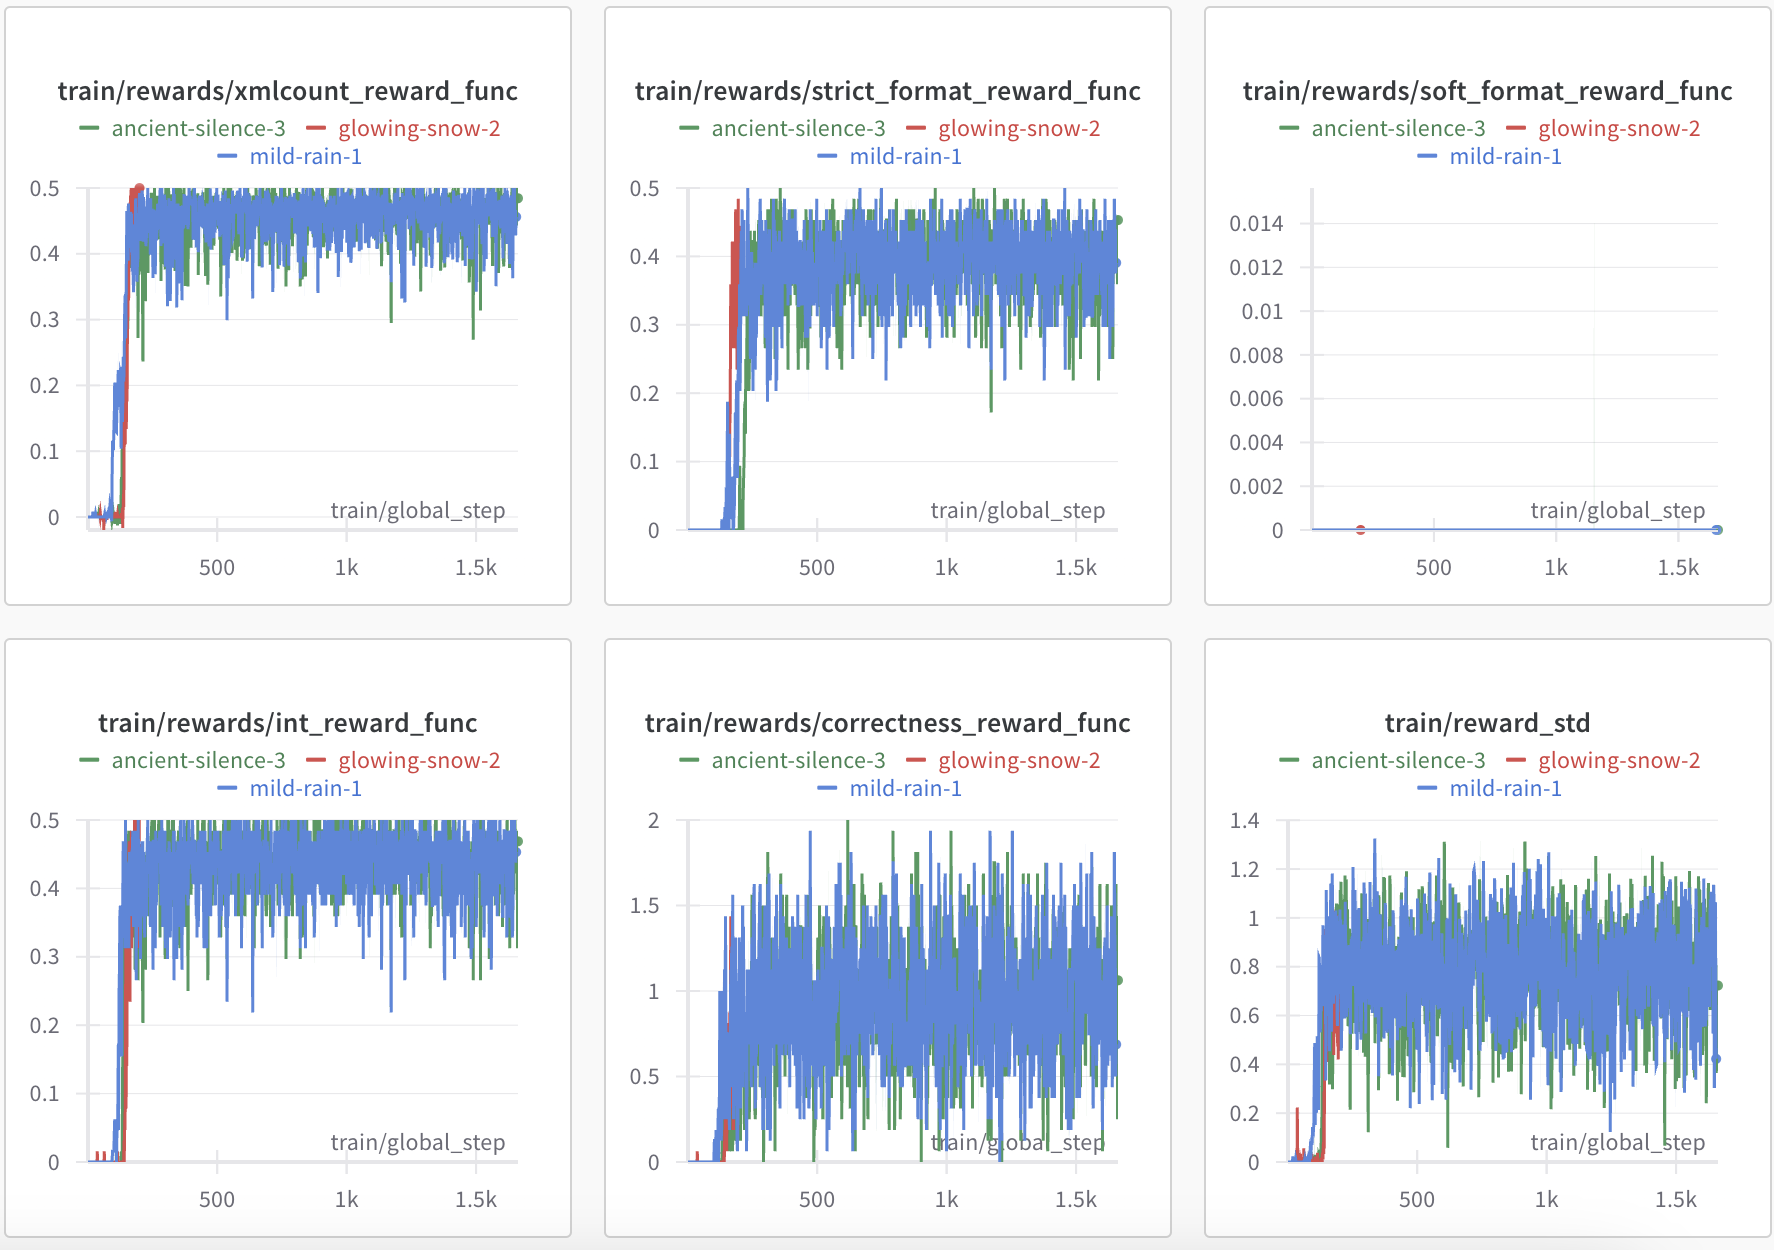

https://huggingface.co/docs/trl/main/en/grpo_trainer

#环境准备
pip install modelscope
pip install torch
pip install transformers
pip install trl

#模型下载
mkdir ./Qwen2.5-0.5B-Instruct
modelscope download --model Qwen/Qwen2.5-0.5B-Instruct --local_dir ./Qwen2.5-0.5B-Instruct

#数据集拷贝
cp -r /root/autodl-fs/gsm8k /root/autodl-tmp/


&emsp;&emsp;数据集选自OpenAI/GSM8K数据集：https://huggingface.co/datasets/openai/gsm8k

# 1.模型&数据集加载

In [1]:
from modelscope import AutoModelForCausalLM, AutoTokenizer

In [2]:
model_name = "./Qwen2.5-0.5B-Instruct"

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [5]:
prompt = "Joy can read 8 pages of a book in 20 minutes. How many hours will it take her to read 120 pages?"

In [6]:
messages = [
    {"role": "user", "content": prompt}
]

In [7]:
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

In [8]:
text,model_inputs

('<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nJoy can read 8 pages of a book in 20 minutes. How many hours will it take her to read 120 pages?<|im_end|>\n<|im_start|>assistant\n',
 {'input_ids': tensor([[151644,   8948,    198,   2610,    525,   1207,  16948,     11,   3465,
             553,  54364,  14817,     13,   1446,    525,    264,  10950,  17847,
              13, 151645,    198, 151644,    872,    198,  79771,    646,   1349,
             220,     23,   6816,    315,    264,   2311,    304,    220,     17,
              15,   4420,     13,   2585,   1657,   4115,    686,    432,   1896,
            1059,    311,   1349,    220,     16,     17,     15,   6816,     30,
          151645,    198, 151644,  77091,    198]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [9]:
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

In [10]:
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
response

'To determine how long it takes Joy to read 120 pages, we first need to find out how long she spends reading one page and then use that information to calculate the total time for 120 pages.\n\n1. **Calculate the reading rate per minute:**\n   Joy reads 8 pages in 20 minutes. Therefore, her reading rate is:\n   \\[\n   \\text{Reading rate} = \\frac{8 \\text{ pages}}{20 \\text{ minutes}} = \\frac{8}{20} = \\frac{2}{5} \\text{ pages per minute}\n   \\]\n\n2. **Determine the time to read one page:**\n   If Joy reads at a rate of \\(\\frac{2}{5}\\) pages per minute, then to read one page, she would take:\n   \\[\n   \\text{Time to read one page} = \\frac{1 \\text{ page}}{\\frac{2}{5} \\text{ pages per minute}} = \\frac{1}{\\frac{2}{5}} = \\frac{1 \\times 5}{2} = \\frac{5}{2} \\text{ minutes} = 2.5 \\text{ minutes}\n   \\]\n   \n3. **Calculate the total time to read 120 pages:**\n   If it takes her 2.5 minutes to read one page, then to read 120 pages, it would take:\n   \\[\n   \\text{Total

pip install datasets

In [12]:
from datasets import load_dataset
data = load_dataset('gsm8k')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [13]:
data

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})

In [14]:
data['train'][0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}

# 2.配置 wandb

&emsp;&emsp;在大规模模型训练中，我们往往需要监控和分析大量的训练数据，而WandB可以帮助我们实现这一目标。它提供了以下几个重要的功能：

**实时可视化**：WandB可以实时展示训练过程中关键指标的变化，如损失函数、学习率、训练时间等。通过这些可视化数据，我们能够直观地了解模型的训练进展，快速发现训练中的异常或瓶颈。

**自动记录与日志管理**：WandB会自动记录每次实验的参数、代码、输出结果，确保实验结果的可追溯性。无论是超参数的设置，还是模型的架构调整，WandB都能够帮助我们完整保留实验记录，方便后期对比与调优。

**支持中断与恢复训练**：在长时间的预训练任务中，系统中断或需要暂停是常见的情况。通过WandB的checkpoint功能，我们可以随时恢复训练，从上次中断的地方继续进行，避免数据和时间的浪费。

**多实验对比**：当我们尝试不同的模型配置或超参数时，WandB允许我们在多个实验之间轻松进行对比分析，帮助我们选择最优的模型配置。

**团队协作**：WandB还支持团队协作，多个成员可以共同查看实验结果，协同调试模型。这对研究和项目开发中团队的合作非常有帮助。

1) 注册wandb：https://wandb.ai/site

!pip install wandb

In [15]:
import wandb

In [ ]:
wandb.login(key="key")

In [ ]:
wandb.init(project="GRPO-train")

# 3.开始进行GRPO训练

In [19]:
import re
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import GRPOConfig, GRPOTrainer

In [20]:
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

# 3.1 处理数据集

In [21]:
def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

In [22]:
test_s1='''
sasa<answer>
yes,let's study llm
</answer>saasa
'''

In [23]:
extract_xml_answer(test_s1)

"yes,let's study llm"

In [24]:
def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

In [25]:
test_s2='Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'


In [26]:
#从数据集中获得最终标准答案
extract_hash_answer(test_s2)

'72'

In [27]:
def get_gsm8k_questions(split = "train") -> Dataset:
    data = load_dataset('gsm8k')[split] # type: ignore
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role':'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

In [28]:
dataset=get_gsm8k_questions()

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [29]:
dataset['question'][0],dataset['answer'][0],dataset['prompt'][0]

('Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 '72',
 [{'content': '\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\n',
   'role': 'system'},
  {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
   'role': 'user'}])

# 3.2 奖励函数

- correctness_reward_func：根据正确性对答案进行奖励。
- int_reward_func：根据是否为数字格式对输出进行奖励。
- strict_format_reward_func：根据严格的格式要求检查并奖励。
- soft_format_reward_func：根据稍微宽松的格式要求检查并奖励。
- count_xml：计算文本中的 XML 标签结构并给予奖励。
- xmlcount_reward_func：为每个输出计算 XML 标签结构的符合度并返回奖励。

In [30]:
# 答案完全正确得2分（是按照要求的xml格式，且是整数，且答案正确），否则0分
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

In [31]:
# 答案是整数（是<answer></answer>得xml格式，且是整数）得0.5分，否则0分
def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

In [32]:
# 答案严格符合<reasoning>{reasoning}</reasoning><answer>{answer}</answer>的格式（换行也要正确）得0.5分，否则0分
def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

In [33]:
# 答案没有强制要求换行符，只要标签之间有任何空白字符（包括空格或换行符）即可，符合则得0.5分，否则得0分
def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

In [34]:
# 根据<reasoning><answer>标签是否出现，位置是否正确打分，0～0.5分
def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

In [35]:
#计算一个批次的xml得分
def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

# 3.3 GRPO训练

In [36]:
model_name = "Qwen2.5-0.5B-Instruct"

output_dir="outputs/Qwen2.5-0.5B-reasoning-GRPO"
run_name="Qwen2.5-0.5B-GRPO-gsm8k"

In [37]:
training_args = GRPOConfig(
    output_dir=output_dir,
    run_name=run_name,
    learning_rate=5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type='cosine',
    logging_steps=1,
    bf16=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    num_generations=8,
    max_prompt_length=256,
    max_completion_length=200,
    num_train_epochs=1,
    save_steps=100,
    max_grad_norm=0.1,
    log_on_each_node=False,
    use_vllm=False,
    vllm_gpu_memory_utilization=.3,
    vllm_device="cuda:0",
    report_to="wandb" 
)

In [38]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=None
).to("cuda")

In [39]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [40]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func],
    args=training_args,
    train_dataset=dataset,
)

In [ ]:
trainer.train()

trainer.save_model(output_dir)

-------------------- Question:
Ahmed and Emily are having a contest to see who can get the best grade in the class. There have been 9 assignments and Ahmed has a 91 in the class. Emily has a 92. The final assignment is worth the same amount as all the other assignments. Emily got a 90 on the final assignment. What is the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers? 
Answer:
100 
Response:
To determine the minimum grade Ahmed needs to get to beat Emily, we need to compare their current grade and the necessary grade for both of them to achieve perfect scores across all assignments.

First, let's denote the grades Ahmed gets on the remaining assignments as \( a, b, c, \) and \( d \). We know the following:

- Ahmed's current grade: \( a = 91 \)
- Emily's current grade: \( e = 92 \)
- The final assignment grade: \( f = 90 \)

The total number of assignments is 9.

To beat Emily, Ahmed needs a higher grade than Emily and she also needs to score a higher gr

Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


-------------------- Question:
In a graveyard, there are 20 skeletons.  Half of these skeletons are adult women, and the remaining number are split evenly between adult men and children.  If an adult woman has 20 bones in their body, and a male has 5 more than this, and a child has half as many as an adult woman, how many bones are in the graveyard? 
Answer:
375 
Response:
First, let's break down the problem piece by piece.

1. We know there are 20 skeletons in total.
2. Half of them are adult women. So, there are 20 skeletons / 2 = 10 adult women.
3. The remaining 10 skeletons are split evenly between adult men and children. So, there are 10 skeletons / 2 = 5 adult men, and 10 skeletons / 2 = 5 children.

Next, we need to find out the number of bones per each gender:

1. An adult woman has 20 bones.
2. A male has 20 + 5 = 25 bones.
3. A child has 20 / 2 = 10 bones.

Now, let's calculate the total number of bones on the graveyard:

- Total number of bones = Bones from adult women + Bon

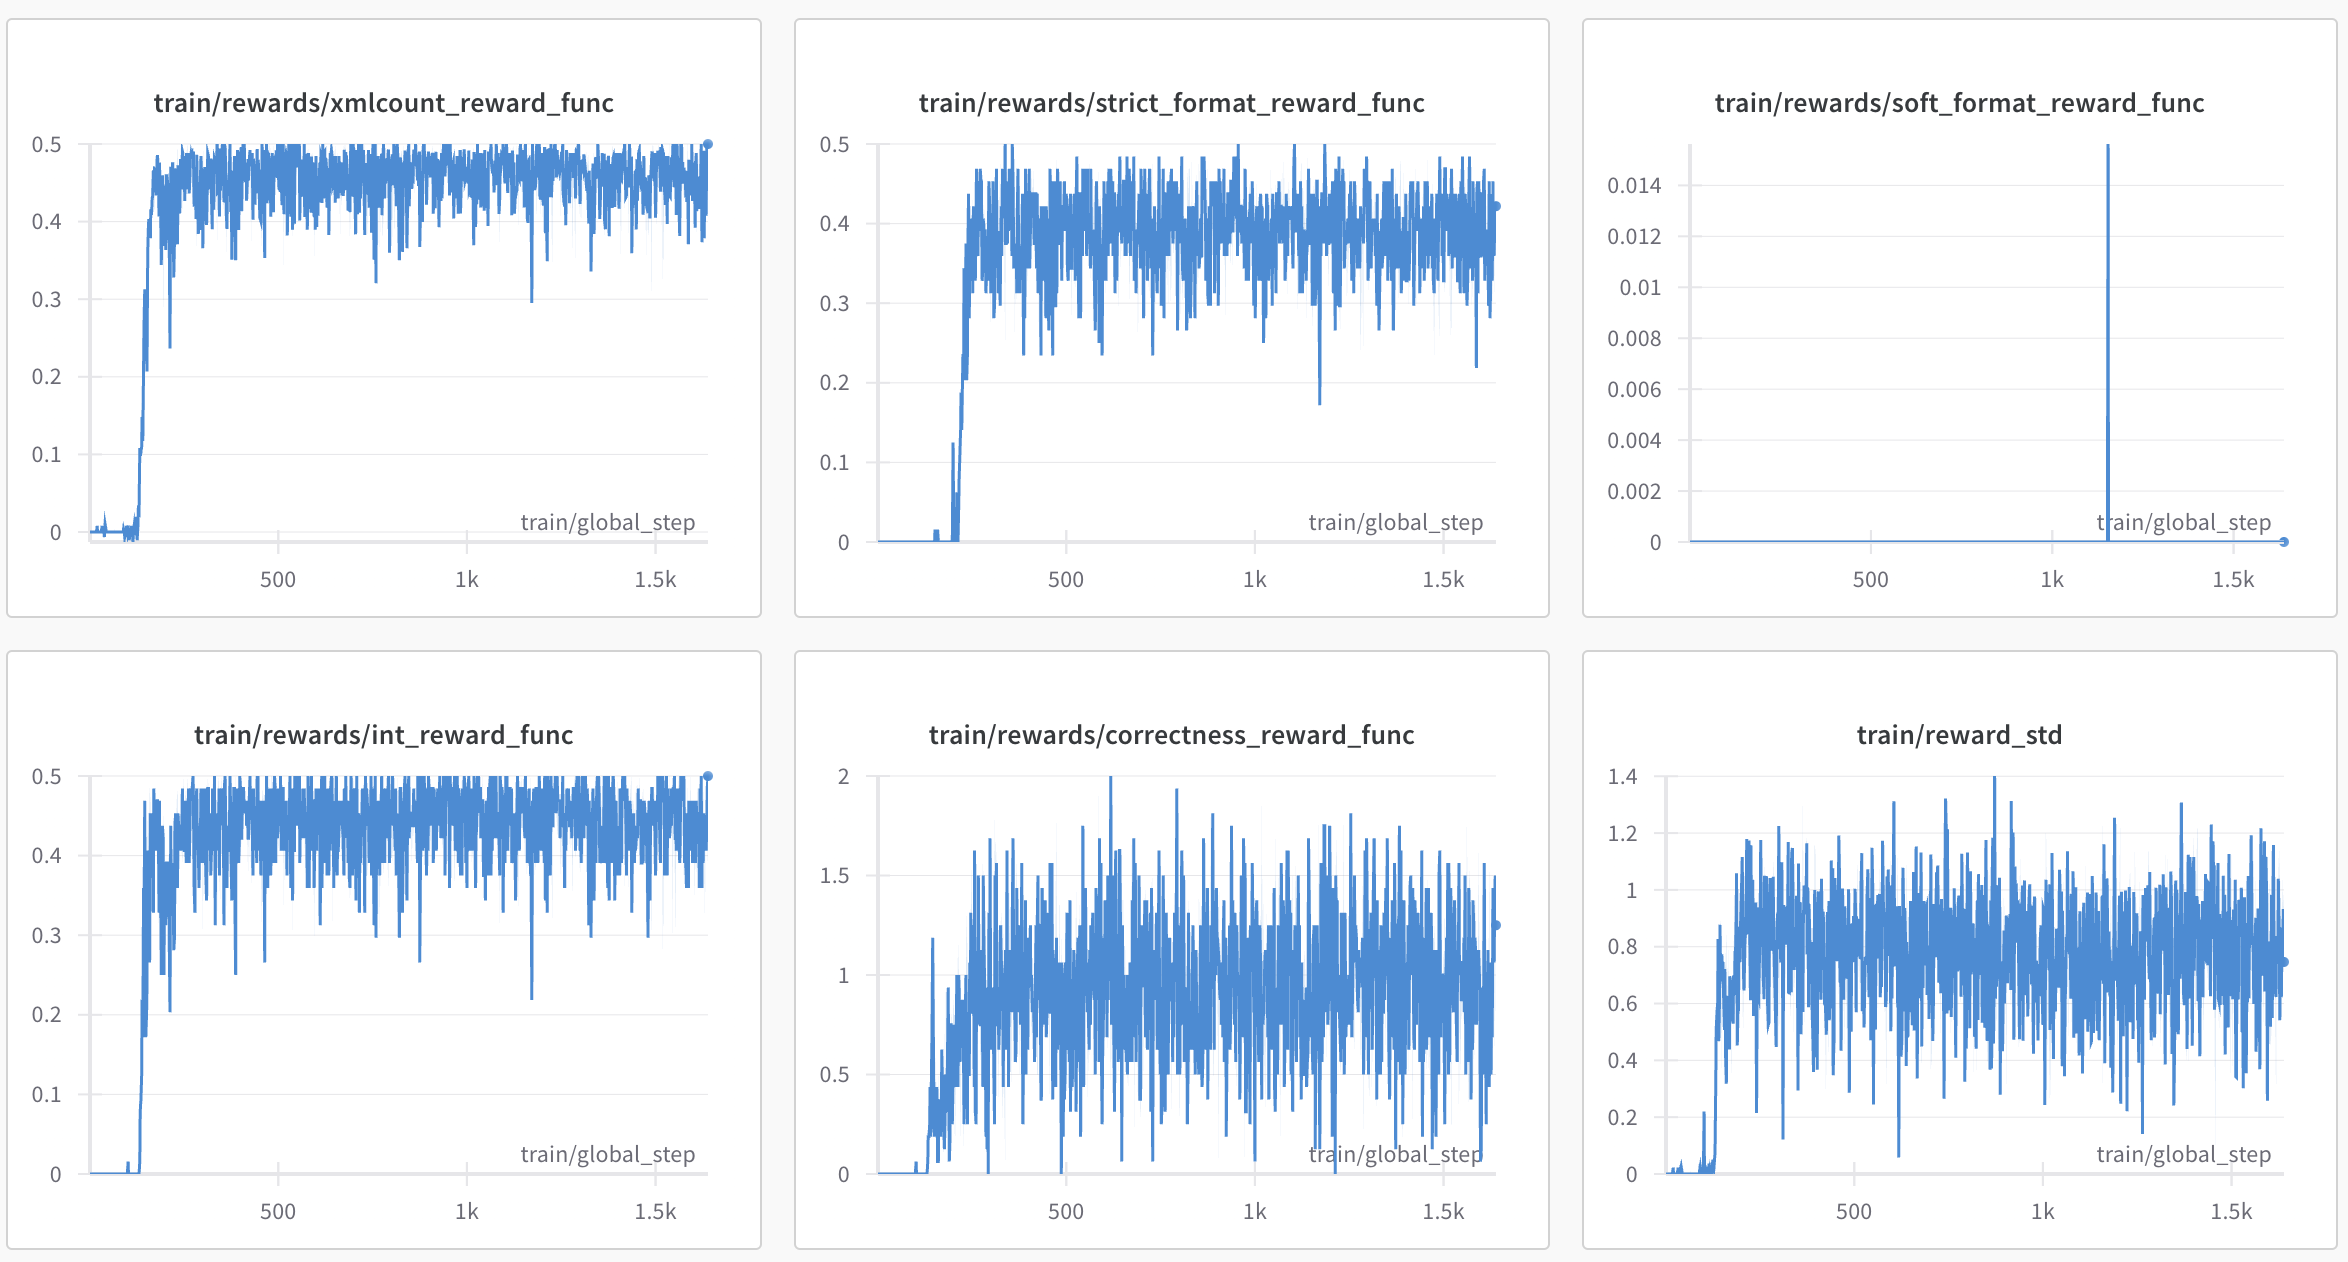